## A Taxonomy of TN Legislation

Using NLP, I look to answer the question: **What (state) legislation should I pay attention to?**

This might include legislation that:

- pertains to local issues in the city/town/county where I live
- pertains to issues I care about (e.g.: education)
- is introduced by my Representative/Senator
- is contentious (comes down to a close or party line vote)

and might not include legislation that:

- is uncontroversial (e.g., probably going to pass unanimously)
- has no chance of passing

Of course, these categories aren't mutually exclusive. I tag legislation meeting each characteristic individually so that we might look at bills meeting any combination of these criteria.

In [1]:
# Preliminaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_colwidth = 1000

Data comes from [OpenStates](https://openstates.org/), which provides comprehensive information pertaining to state legislators and legislation for all 50 states, DC and Puerto Rico, including bill text, topics, sponsors, progress through committees, amendments, vote tallies and votes by individual legislators.

OpenStates makes data available via an API, which I access using the [pyopenstates](http://docs.openstates.org/en/latest/api/) module.

In [2]:
bills = pd.read_csv('../data/bills.csv')

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'] = bills['title'].replace(to_replace = ' - Amends.+$', value = '', regex = True)

bills.head(10)

,bill_id,id,session,subjects,title,sponsors
0,SB 107,TNB00030250,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Bell; Faison
1,HB 228,TNB00030742,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Faison; Bell
2,HB 2716,TNB00037681,110,Municipal and County Issues,"Maury County - Subject to local approval, creates a county financial management system to administer the finances of the county for all funds of the various departments, agencies, and boards that are handled by the county trustee. -",Butt; Hensley
3,SB 2745,TNB00037699,110,Municipal and County Issues,"Maury County - Subject to local approval, creates a county financial management system to administer the finances of the county for all funds of the various departments, agencies, and boards that are handled by the county trustee. -",Hensley; Butt
4,HB 1905,TNB00035358,110,"Federal, State, and Local Relations","Capitol - As enacted, administratively attaches the David Crockett commission to the department of finance and administration; creates a separate account within the treasury to be used to erect a monument; authorizes state and private funds to be used to erect a monument with intent that no state funds be used until private funding exhausted.",Hawk; Southerland
5,SB 1868,TNB00035376,110,"Federal, State, and Local Relations","Capitol - As enacted, administratively attaches the David Crockett commission to the department of finance and administration; creates a separate account within the treasury to be used to erect a monument; authorizes state and private funds to be used to erect a monument with intent that no state funds be used until private funding exhausted.",Southerland; Hawk
6,SB 5,TNB00030075,110,Judiciary,"Judicial Districts - As enacted, creates one additional trial court each in the sixteenth, nineteenth, and twenty-first judicial districts; requires the speaker of the senate and the speaker of the house to establish an advisory task force to review the composition of Tennessee's current judicial districts.",Green; Johnson
7,HB 10,TNB00030110,110,Judiciary,"Judicial Districts - As enacted, creates one additional trial court each in the sixteenth, nineteenth, and twenty-first judicial districts; requires the speaker of the senate and the speaker of the house to establish an advisory task force to review the composition of Tennessee's current judicial districts.",Johnson; Green
8,HB 75,TNB00030341,110,Education,"Education - As enacted, provides that no adverse action may be taken against any student, teacher, school, or LEA based, in whole or in part, on student achievement data generated from the 2017-2018 TNReady assessments.",Kane; Gresham
9,SB 200,TNB00030509,110,Crime,"Criminal Offenses - As enacted, includes within the offense of especially aggravated stalking a person 18 years of age or older who commits the offense of stalking or aggravated stalking against a victim who is less than 12 years of age at any time during the person's course of conduct.",Swann; Williams


From this, I can tag legislation introduced by my legislators, pertaining to the city/county where I live, and relates to subjects I'm interested in.

In [3]:
# Use pyopenstates to identify my legislators from location
from pyopenstates import set_api_key, locate_legislators

set_api_key('') # Get key here: https://openstates.org/api/register/

my_legislators = [i.get('last_name') for i in locate_legislators(36.157612, -86.767337)]

print(my_legislators)

# Tag legislation introducted by my legislators
bills['my_legislators'] = bills['sponsors'].str.contains('|'.join(my_legislators)).fillna(False).astype(int)

['Harper', 'Beck']


In [4]:
# Identify my city, county from location
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = 'my-application')

location = geolocator.reverse((36.157612, -86.767337))

my_city, my_county = [location.raw.get('address').get(i) for i in ['city', 'county']]

print(my_city + ', ' + my_county)

if my_city == "Nashville-Davidson":
    my_city = "Nashville"

# Tag legislation mentioning my city or county from location
bills['my_city_county'] = bills['title'].str.contains(my_city + '|' + my_county).astype(int)

Nashville-Davidson, Davidson County


In [5]:
# Get a list of possible subjects
bills['subjects'].replace(to_replace = ';.+', value = '', regex = True).value_counts()

Education                               2461
Legal Issues                            1985
Health                                  1396
Transportation                          1253
Municipal and County Issues             1181
Budget, Spending, and Taxes             1035
Drugs                                   1017
Government Reform                        959
Labor and Employment                     822
Business and Consumers                   611
Housing and Property                     610
Commerce                                 591
Crime                                    588
Campaign Finance and Election Issues     485
Federal, State, and Local Relations      456
Judiciary                                427
Environmental                            396
Legislative Affairs                      386
Guns                                     336
Family and Children Issues               328
Public Services                          297
Other                                    277
State Agen

In [6]:
# Tag legislation pertaining to subjects I'm interested in
my_subjects = ['Education']

bills['my_subjects'] = bills['subjects'].str.contains('|'.join(my_subjects)).fillna(0).astype(int)

In Tennessee, a bill goes through the following [steps](http://www.capitol.tn.gov/about/billtolaw.html) (roughly) to become law:

* Introduced
* Passed on First Consideration
* Passed on Second Consideration
* Referred to Committee(s)
* Placed on Calendar for Third Consideration
    * On Third Consideration, opened for debate and amendment
* Passed on Third Consideration
* Reconcile Senate and House versions
* Signed by Governor or allowed to become law without signature

We can observe whether bills make it through each of these steps.

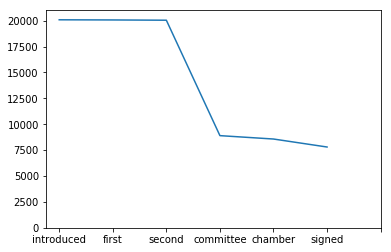

In [7]:
actions = pd.read_csv('../data/actions.csv')

actions.drop_duplicates(['action', 'actor', 'date', 'session', 'bill_id'], inplace = True)
actions['action'].fillna('', inplace = True)

intro = actions.query('action.str.contains("Filed for introduction|Filed for intro.")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(introduced = 1)

first = actions.query('action.str.contains("Passed on First Consideration|P1C")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(first = 1)

second = actions.query('action.str.contains("Passed on Second Consideration|P2C")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(second = 1)

committee = actions.query('action.str.contains("H. Placed on Regular Calendar|H. Placed on Consent Calendar|Placed on Senate Consent Calendar|Placed on Senate Regular Calendar")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(committee = 1)

chamber = actions.query('action.str.contains("Passed H.|Passed Senate|Passed S.")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(chamber = 1)

signed = actions.query('action.str.contains("Signed by Governor")', engine = 'python')[['session', 'bill_id']] \
    .drop_duplicates() \
    .assign(signed = 1)
    
bills = bills \
    .merge(intro, how = 'left', on = ['session', 'bill_id'], validate = '1:1') \
    .merge(first, how = 'left', on = ['session', 'bill_id'], validate = '1:1') \
    .merge(second, how = 'left', on = ['session', 'bill_id'], validate = '1:1') \
    .merge(committee, how = 'left', on = ['session', 'bill_id'], validate = '1:1') \
    .merge(chamber, how = 'left', on = ['session', 'bill_id'], validate = '1:1') \
    .merge(signed, how = 'left', on = ['session', 'bill_id'], validate = '1:1')

bills.fillna(value = {'introduced': 0, 'first': 0, 'second': 0, 'committee': 0, 'chamber': 0, 'signed': 0}, inplace = True)

bills[['introduced', 'first', 'second', 'committee', 'chamber', 'signed']] \
    .agg(sum) \
    .plot(xticks = range(7), ylim = (0, 21000))

Note that companion bills are often introduced in both the House and Senate, so these counts overcount by about 2x.

The big gatekeeper is getting past committees; most bills don't get past committee, but once they do, they stand a good chance of passing. I'll want to predict which bills get past committee.

What do vote margins look like once bills get past committee?

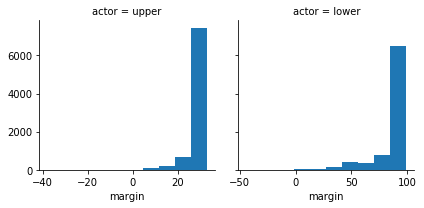

In [8]:
margin = actions.query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine = 'python') \
    .assign(margin = actions['ayes'] - actions['nays']) \
    .loc[:, ['session', 'bill_id', 'actor', 'margin']]

g = sns.FacetGrid(margin, col = "actor", sharex = False)
g = g.map(plt.hist, "margin")

Once past committee, many bills are uncontroversial (pass by an all-0 vote). I'll also identify uncontroversial bills so that we can de-prioritize those.

In [9]:
actions['uncontroversial'] = pd.Series(actions['nays'] <= 1).astype(int)

uncontroversial = actions \
    .query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine = 'python') \
    .query('actor == "upper" & bill_id.str.contains("SB") | actor == "lower" & bill_id.str.contains("HB")', engine = 'python') \
    .groupby(['session', 'bill_id']) \
    .agg({'uncontroversial': 'min'}) \
    .reset_index(drop = False)

bills = bills.merge(uncontroversial, how = 'left', on = ['session', 'bill_id'], validate = '1:1')

bills['uncontroversial'].fillna(0, inplace = True)

In [10]:
bills.head(1)

,bill_id,id,session,subjects,title,sponsors,my_legislators,my_city_county,my_subjects,introduced,first,second,committee,chamber,signed,uncontroversial
0,SB 107,TNB00030250,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Bell; Faison,0,0,0,1,1.0,1.0,1.0,1.0,1.0,1.0


Counts of bills getting past committee, signed into law, and uncontroversial bills (recall about 2x overcounting of companion bills):

In [11]:
bills['committee'].value_counts()

0.0    11188
1.0     8901
Name: committee, dtype: int64

In [12]:
bills['signed'].value_counts()

0.0    12287
1.0     7802
Name: signed, dtype: int64

In [13]:
bills['uncontroversial'].value_counts()

0.0    13245
1.0     6844
Name: uncontroversial, dtype: int64

Of course, we know what happens to bills retrospectively. However, it would be helpful to know whether bills will go to a vote and/or be uncontroversial as they are introduced so that one might be able to influence legislation through calling one's legislators, etc. 

I use **machine learning** to predict these outcomes. The idea is to information about what bills have gone to a vote/been uncontroversial in the past to predict which bills will go to a vote/be uncontroversial in the future.

I use spaCy to do some preprocessing (drop stop words, lemmatize, and keep only certain parts of speech). I then use a TF-IDF representation and regularized logistic regression for classification.

In [14]:
import spacy
from nltk.corpus import stopwords

# Use spaCy annotator and convert to data frame with one token per row
nlp = spacy.load('en')

token = []
lemma = []
pos = []

for doc in nlp.pipe(bills['title'], batch_size = 50):
    token.append([n.text for n in doc])
    lemma.append([n.lemma_ for n in doc])
    pos.append([n.pos_ for n in doc])
    
annotation_df = pd.DataFrame({
    'token': pd.Series(token).apply(pd.Series).stack(),
    'lemma': pd.Series(lemma).apply(pd.Series).stack(),
    'pos': pd.Series(pos).apply(pd.Series).stack(),
})

# Drop and modify tokens depending of part of speech
# https://spacy.io/api/annotation#pos-tagging
annotation_df = annotation_df[annotation_df['pos'].isin(['NOUN', 'VERB', 'PROPN'])]

# Drop anything with nonword characters
annotation_df = annotation_df[~annotation_df['token'].str.contains("\\W|[0-9]")]

# Drop stopwords
annotation_df = annotation_df[~annotation_df['token'].isin(stopwords.words('english'))]

preprocess = pd.Series([annotation_df.loc[i]['lemma'].str.cat(sep = ' ') for i in range(len(bills))])

In [15]:
# A TF-IDF representation
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(min_df = 10, ngram_range=(1, 3))

X_tfidf = tf.fit_transform(preprocess)

To mimic prediction, I use the most recent session as test set and all prior as training:

In [16]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

In [17]:
train_count = sum(bills['session'] != 110)

X_train = X_tfidf[:train_count].toarray()
X_test = X_tfidf[train_count:].toarray()

Y_train_vote = bills['committee'][:train_count]
Y_test_vote = bills['committee'][train_count:]

Y_train_uncontroversial = bills['uncontroversial'][:train_count]
Y_test_uncontroversial = bills['uncontroversial'][train_count:]

I train a model to identify bills which go to a vote, predict on the test set, then check accuracy:

In [18]:
# Elastic Net
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': 10.0 ** -np.arange(3, 7)
}

elastic_net = GridSearchCV(SGDClassifier(loss = "log", max_iter = 250, l1_ratio = 1), params, cv = 5)

elastic_net_vote = elastic_net.fit(X_train, Y_train_vote)

accuracy_score(elastic_net_vote.predict(X_test), Y_test_vote)

0.9465815861440292

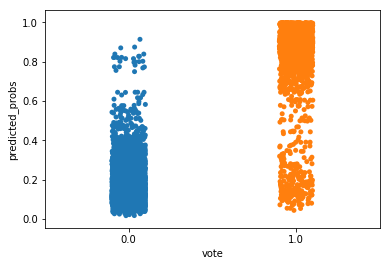

In [19]:
data = pd.DataFrame({
    'vote': Y_test_vote,
    'predicted_probs': elastic_net_vote.predict_proba(X_test)[:, 1]
})

sns.stripplot(x = 'vote', y = 'predicted_probs', data = data, jitter = True)

Save predictions for later:

In [20]:
predict_vote = elastic_net_vote.predict(X_test)

Repeat to predict uncontroversial bills:

In [21]:
# Predict uncontroversial
elastic_net_uncontroversial = elastic_net.fit(X_train, Y_train_uncontroversial)

accuracy_score(elastic_net_uncontroversial.predict(X_test), Y_test_uncontroversial)

0.9281677301731996

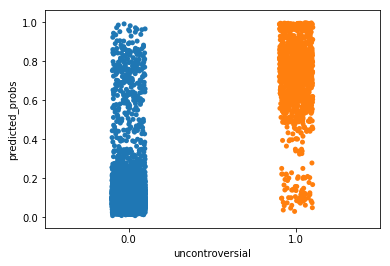

In [22]:
data = pd.DataFrame({
    'uncontroversial': Y_test_uncontroversial,
    'predicted_probs': elastic_net_uncontroversial.predict_proba(X_test)[:, 1]
})

sns.stripplot(x = 'uncontroversial', y = 'predicted_probs', data = data, jitter = True)

In [23]:
predict_uncontroversial = elastic_net_uncontroversial.predict(X_test)

Check that we get some bills predicted to get a vote but not be uncontroversial:

In [24]:
sum(predict_vote != predict_uncontroversial)

170

In [25]:
# Predictions
prediction_set = bills[bills['session'] == 110] \
    .assign(predict_vote = predict_vote,
            predict_uncontroversial = predict_uncontroversial) \
    .loc[:, ['title', 'my_legislators', 'my_city_county', 'my_subjects', 'predict_vote', 'predict_uncontroversial']]

# Sort results by descending order of the number of categories matched
prediction_set['counts'] = \
    prediction_set['my_city_county'] + prediction_set['my_legislators'] + prediction_set['my_subjects'] + \
    ((prediction_set['predict_vote'] == 1) & (prediction_set['predict_uncontroversial'] == 0)).astype(int)

An answer to "What legislation should I pay attention to?" might look like the following:

In [26]:
prediction_set \
    .query('my_city_county == 1 | my_legislators == 1 | my_subjects == 1 | (predict_vote == 1 & predict_uncontroversial == 0)') \
    .sort_values(by = 'counts', ascending = False) \
    .head(10)

,title,my_legislators,my_city_county,my_subjects,predict_vote,predict_uncontroversial,counts
3786,"Education - As introduced, creates a tuition assistance program from proceeds of the state lottery to develop a two-year pilot program that allows Fairview High School students to participate in dual enrollment at Columbia State Community College and earn an associate degree in advanced manufacturing courses.",0,0,1,1.0,0.0,2
1784,"Education - As introduced, changes the treatment of certain records obtained in the search for a director of schools or any chief public administrative officer from open for public inspection to confidential with certain exceptions; makes confidential, with certain exceptions, the records relating to the process of searching for and selecting of any applicant for a president of a state university, the president of a community college, and the president of a college of applied technology.",0,0,1,1.0,0.0,2
2370,"Local Education Agencies - As introduced, deletes the requirement that local school systems must sell all surplus property within 90 days of its being declared surplus; revises the advertising requirements for local school systems selling surplus property.",1,0,1,0.0,0.0,2
5337,"Education - As introduced, requires the Tennessee financial literacy commission to post its annual report on the department of the treasury website.",1,0,1,0.0,0.0,2
586,"Education - As introduced, requires driver education courses to include an area of instruction on the impact of talking and texting on a mobile phone on a student's driving abilities.",1,0,1,0.0,0.0,2
3711,"School Transportation - As introduced, authorizes LEAs, directly or by contract, to install, operate, or maintain cameras on the outside of school buses to record vehicles unlawfully passing stopped school buses; allows persons cited to pay the fine out of court; imposes additional penalties that apply under certain circumstances.",0,0,1,1.0,0.0,2
1454,"Education - As introduced, allows the governing body of a public charter school to make the annual progress report to the sponsor of the school, the chartering authority, and the commissioner of education in an electronic format.",1,0,1,1.0,1.0,2
1455,"Education - As introduced, allows the governing body of a public charter school to make the annual progress report to the sponsor of the school, the chartering authority, and the commissioner of education in an electronic format.",0,0,1,1.0,0.0,2
584,"Education - As introduced, requires a local board of education to hold a hearing within 30 days of, rather than within a reasonable time after, its receipt of an application for a hearing to contest the reasonableness of a student assignment.",0,0,1,1.0,0.0,2
4549,"Lottery, Scholarships and Programs - As introduced, specifies that semester hours earned in ROTC courses by ROTC students do not count toward the semester hour limitation for receipt of the Tennessee HOPE scholarship; excludes grades received in ROTC courses from the calculation of an ROTC student's grade point average for Tennessee HOPE scholarship purposes.",0,0,1,1.0,0.0,2
